##Control Access Network Simulator and Instrusion Detection System using Machine Learning


Cell 1 – Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# For reproducibility
np.random.seed(42)


Cell 2 - Define CAN message simulation

In [ ]:
def generate_normal_can_traffic(
    num_messages=8000,
    base_time_step=0.01
):

    #normal CAN traffic as a DataFrame with:
    #timestamp, can_id, dlc, data_bytes (8 bytes)

    # Example CAN IDs for different ECUs
    normal_ids = [0x100, 0x200, 0x300, 0x400]  # engine, brake, steering, speed (just as labels)

    timestamps = []
    can_ids = []
    dlcs = [] #Data Length Code or Payload Size
    data_bytes_list = []

    current_time = 0.0

    for _ in range(num_messages):
        # Time moves forward with some jitter
        current_time += np.random.exponential(base_time_step)
        timestamps.append(current_time)

        # Pick one ECU / CAN ID
        cid = int(np.random.choice(normal_ids))
        can_ids.append(cid)

        # DLC: often 8 for many messages
        dlc = 8
        dlcs.append(dlc)

        # For realism, generate different patterns per ID
        if cid == 0x100:  # engine
            # Example: RPM-ish data
            data = np.random.normal(loc=120, scale=15, size=dlc)
        elif cid == 0x200:  # brake
            # Mostly 0, sometimes 1
            data = np.random.binomial(1, p=0.1, size=dlc)
        elif cid == 0x300:  # steering
            data = np.random.normal(loc=0, scale=5, size=dlc)  # centered at 0
        else:  # 0x400 speed
            data = np.random.normal(loc=60, scale=10, size=dlc)

        # Clamp to byte range 0–255 and make integers
        data = np.clip(data, 0, 255).astype(int)
        data_bytes_list.append(data)

    df = pd.DataFrame({
        "timestamp": timestamps,
        "can_id": can_ids,
        "dlc": dlcs
    })

    # Expand data bytes into separate columns data_0 ... data_7
    data_array = np.vstack(data_bytes_list)
    for i in range(data_array.shape[1]):
        df[f"data_{i}"] = data_array[:, i]

    df["is_attack"] = 0  # label for evaluation later
    return df

normal_df = generate_normal_can_traffic()
normal_df.head()

,timestamp,can_id,dlc,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,is_attack
0,0.004693,256,8,128,110,102,152,118,106,106,113,0
1,0.015216,256,8,111,112,111,106,80,134,132,97,0
2,0.016719,1024,8,62,52,61,59,71,58,54,79,0
3,0.016852,256,8,110,115,110,147,119,104,132,101,0
4,0.020588,512,8,0,0,0,0,0,0,1,0,0


Cell 3 – Simulate attack scenarios

In [ ]:
def generate_dos_attack(
    num_messages=1500,
    start_time=50.0,
    flood_id=0x666,
    time_step=0.0005
):
    timestamps = []
    can_ids = []
    dlcs = []
    data_bytes_list = []

    current_time = start_time

    for _ in range(num_messages):
        current_time += np.random.exponential(time_step)  # very small gap
        timestamps.append(current_time)
        can_ids.append(int(flood_id))
        dlc = 8
        dlcs.append(dlc)

        # Random junk data
        data = np.random.randint(0, 256, size=dlc)
        data_bytes_list.append(data)

    df = pd.DataFrame({
        "timestamp": timestamps,
        "can_id": can_ids,
        "dlc": dlcs
    })
    data_array = np.vstack(data_bytes_list)
    for i in range(data_array.shape[1]):
        df[f"data_{i}"] = data_array[:, i]

    df["is_attack"] = 1
    return df


def generate_fuzzing_attack(
    num_messages=1000,
    start_time=60.0,
    time_step=0.01
):
    timestamps = []
    can_ids = []
    dlcs = []
    data_bytes_list = []

    current_time = start_time
    for _ in range(num_messages):
        current_time += np.random.exponential(time_step)
        timestamps.append(current_time)

        # CAN IDs outside the normal range (e.g. > 0x500)
        cid = int(np.random.randint(0x500, 0x7FF))
        can_ids.append(cid)

        dlc = 8
        dlcs.append(dlc)
        data = np.random.randint(0, 256, size=dlc)
        data_bytes_list.append(data)

    df = pd.DataFrame({
        "timestamp": timestamps,
        "can_id": can_ids,
        "dlc": dlcs
    })
    data_array = np.vstack(data_bytes_list)
    for i in range(data_array.shape[1]):
        df[f"data_{i}"] = data_array[:, i]

    df["is_attack"] = 1
    return df


def generate_suspicious_pattern_attack(
    num_messages=800,
    start_time=70.0,
    time_step=0.02
):

    timestamps = []
    can_ids = []
    dlcs = []
    data_bytes_list = []

    current_time = start_time

    for _ in range(num_messages):
        current_time += np.random.exponential(time_step)
        timestamps.append(current_time)

        # Use brake CAN ID but with weird data patterns
        cid = 0x200
        can_ids.append(int(cid))
        dlc = 8
        dlcs.append(dlc)

        # Brake fully on (1) + absurdly high numeric bytes
        data = np.ones(dlc, dtype=int) * np.random.randint(200, 255)
        data_bytes_list.append(data)

    df = pd.DataFrame({
        "timestamp": timestamps,
        "can_id": can_ids,
        "dlc": dlcs
    })
    data_array = np.vstack(data_bytes_list)
    for i in range(data_array.shape[1]):
        df[f"data_{i}"] = data_array[:, i]

    df["is_attack"] = 1
    return df

dos_df = generate_dos_attack()
fuzz_df = generate_fuzzing_attack()
suspicious_df = generate_suspicious_pattern_attack()

dos_df.head()


,timestamp,can_id,dlc,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,is_attack
0,50.000537,1638,8,64,64,141,239,233,92,19,96,1
1,50.000583,1638,8,83,240,80,157,204,213,191,101,1
2,50.000723,1638,8,91,22,150,31,80,39,165,61,1
3,50.000765,1638,8,84,53,236,40,51,182,93,172,1
4,50.000841,1638,8,177,178,214,69,146,67,48,22,1


Cell 4 – Combine normal + attack traffic

In [ ]:
full_df = pd.concat([normal_df, dos_df, fuzz_df, suspicious_df], ignore_index=True)

# Sort by timestamp like a real log
full_df = full_df.sort_values("timestamp").reset_index(drop=True)

print(full_df["is_attack"].value_counts())
full_df.head()


is_attack
0    8000
1    3300
Name: count, dtype: int64


,timestamp,can_id,dlc,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,is_attack
0,0.004693,256,8,128,110,102,152,118,106,106,113,0
1,0.015216,256,8,111,112,111,106,80,134,132,97,0
2,0.016719,1024,8,62,52,61,59,71,58,54,79,0
3,0.016852,256,8,110,115,110,147,119,104,132,101,0
4,0.020588,512,8,0,0,0,0,0,0,1,0,0


Cell 5 – Feature engineering for ML

In [ ]:
def add_features(df):
    df = df.copy()

    # Time delta between consecutive messages
    df["delta_time"] = df["timestamp"].diff().fillna(0)

    # Normalize CAN IDs to [0, 1] range (roughly)
    df["can_id_normalized"] = df["can_id"] / 0x7FF  # 11-bit max

    # Data bytes stats
    data_cols = [c for c in df.columns if c.startswith("data_")]
    data_values = df[data_cols].values.astype(float)

    df["data_mean"] = data_values.mean(axis=1)
    df["data_std"] = data_values.std(axis=1)

    return df

full_df_feat = add_features(full_df)
full_df_feat.head()


,timestamp,can_id,dlc,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,is_attack,delta_time,can_id_normalized,data_mean,data_std
0,0.004693,256,8,128,110,102,152,118,106,106,113,0,0.000000,0.125061,116.875,15.325122
1,0.015216,256,8,111,112,111,106,80,134,132,97,0,0.010524,0.125061,110.375,16.393120
2,0.016719,1024,8,62,52,61,59,71,58,54,79,0,0.001502,0.500244,62.000,8.366600
3,0.016852,256,8,110,115,110,147,119,104,132,101,0,0.000134,0.125061,117.250,14.385322
4,0.020588,512,8,0,0,0,0,0,0,1,0,0,0.003735,0.250122,0.125,0.330719


Cell 6 – Split into train (normal only) and test (normal + attacks)

In [ ]:
# Columns we will feed into the model
feature_cols = ["can_id_normalized", "delta_time", "data_mean", "data_std"]

# Training data: only normal traffic
train_df = full_df_feat[full_df_feat["is_attack"] == 0]
X_train = train_df[feature_cols].values

# Test data: everything
test_df = full_df_feat
X_test = test_df[feature_cols].values
y_test = test_df["is_attack"].values  # only used for model evaluation

Cell 7 – Train Isolation Forest

In [ ]:
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.15,   # our rough guess of attack proportion
    random_state=42
)

iso_forest.fit(X_train)

# Get anomaly scores and predictions on test set
anomaly_scores = iso_forest.decision_function(X_test)  # higher = more normal
preds = iso_forest.predict(X_test)                     # 1 = normal, -1 = anomaly

# Convert to 0 (normal) / 1 (attack-like) for evaluation
y_pred = (preds == -1).astype(int)

print("Sample anomaly scores:", anomaly_scores[:5])


Sample anomaly scores: [0.03527556 0.00343446 0.08137114 0.0467546  0.11304102]


Cell 8 – Evaluate detection performance

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred))

try:
    auc = roc_auc_score(y_test, -anomaly_scores)  # -score so higher = more anomalous
    print("ROC-AUC:", auc)
except ValueError:
    print("ROC-AUC could not be computed (need both classes present).")


Confusion matrix (rows=true, cols=pred):
 [[6800 1200]
 [   0 3300]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92      8000
           1       0.73      1.00      0.85      3300

    accuracy                           0.89     11300
   macro avg       0.87      0.93      0.88     11300
weighted avg       0.92      0.89      0.90     11300

ROC-AUC: 0.9863607575757576


Cell 9 – Simple visualization (“dashboard feel”)

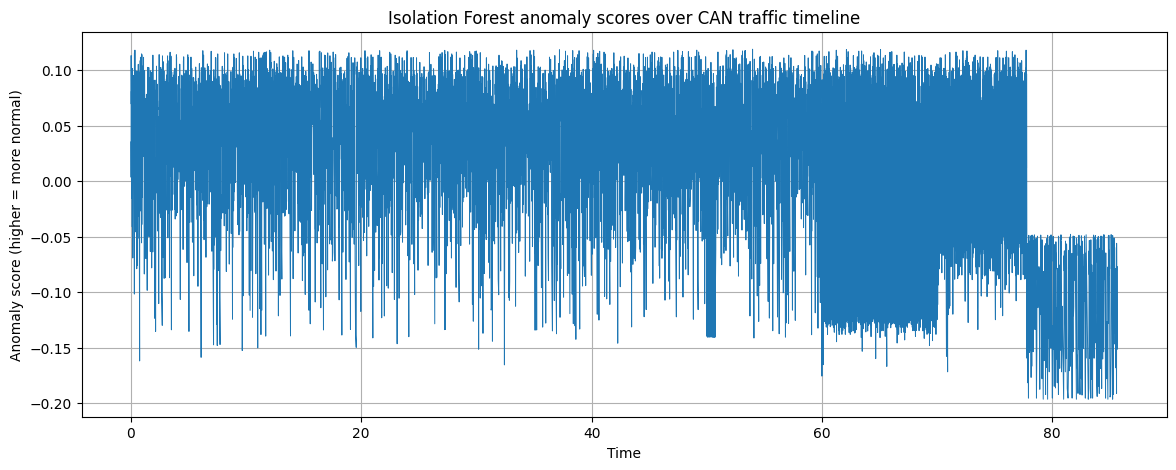

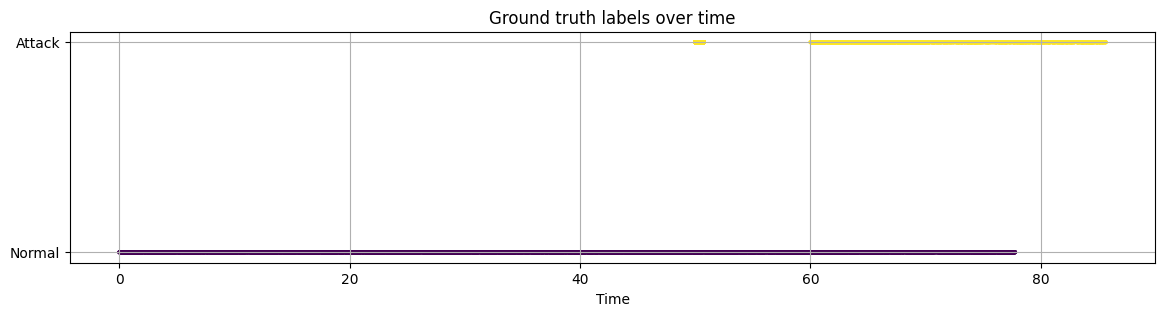

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(test_df["timestamp"], anomaly_scores, linewidth=0.7)
plt.xlabel("Time")
plt.ylabel("Anomaly score (higher = more normal)")
plt.title("Isolation Forest anomaly scores over CAN traffic timeline")
plt.grid(True)
plt.show()

# Highlight where attacks actually were
plt.figure(figsize=(14, 3))
plt.scatter(
    test_df["timestamp"],
    y_test,
    c=y_test,
    s=4
)
plt.yticks([0, 1], ["Normal", "Attack"])
plt.xlabel("Time")
plt.title("Ground truth labels over time")
plt.grid(True)
plt.show()


Cell 10 – Simulated real-time monitoring loop

In [ ]:
tTHRESHOLD = np.percentile(anomaly_scores, 20)  # lower score = more anomalous

print("Alert threshold on anomaly score:", THRESHOLD)

def monitor_stream(df_feat, scores, threshold):
    for i in range(len(df_feat)):
        row = df_feat.iloc[i]
        score = scores[i]
        is_attack_pred = score < threshold
        if is_attack_pred:
            print(
                f"[ALERT] t={row['timestamp']:.3f}, "
                f"can_id=0x{int(row['can_id']):03X}, "
                f"score={score:.3f}"
            )

# For demo, only run over a small slice (otherwise too much output)
demo_slice = slice(0, 300)
monitor_stream(
    full_df_feat.iloc[demo_slice],
    anomaly_scores[demo_slice],
    THRESHOLD
)


Alert threshold on anomaly score: -0.11036710243124821
[ALERT] t=0.757, can_id=0x100, score=-0.162
[ALERT] t=2.079, can_id=0x400, score=-0.124
[ALERT] t=2.143, can_id=0x400, score=-0.135
[ALERT] t=2.414, can_id=0x100, score=-0.110
[ALERT] t=2.722, can_id=0x400, score=-0.130


Cell 11 - Live simulation and side-by-side alerts

In [ ]:
#Note for Sir/TA:
#This cell shows live dashboard.
#Please make sure all previous cells have been run before you test this cell so that this cell has some simulated network data to work with.

from IPython.display import clear_output
import time

def run_live_simulation(
    df_feat,
    model,
    feature_cols,
    threshold,
    delay=0.05,
    max_steps=400
):

    history_t = []
    history_score = []
    alerts = []

    # We only take first max_steps rows for demo
    for i in range(min(max_steps, len(df_feat))):
        row = df_feat.iloc[i]

        # feature vector for this single message
        x = row[feature_cols].values.reshape(1, -1)

        # anomaly score (higher = more normal)
        score = model.decision_function(x)[0]
        t = row["timestamp"]

        history_t.append(t)
        history_score.append(score)

        is_alert = score < threshold
        if is_alert:
            alert_msg = (
                f"[ALERT] t={t:.3f}, "
                f"can_id=0x{int(row['can_id']):03X}, "
                f"score={score:.3f}"
            )
            alerts.append(alert_msg)


        clear_output(wait=True)

        plt.figure(figsize=(14, 4))
        plt.plot(history_t, history_score, marker=".", linewidth=0.7)
        plt.axhline(threshold, linestyle="--")
        plt.xlabel("Time")
        plt.ylabel("Anomaly score")
        plt.title("Live anomaly score over time (Isolation Forest)")
        plt.grid(True)
        plt.show()

        # Show last few alerts as text under the plot
        print("Live Intrusion Alerts (most recent at bottom):")
        if alerts:
            for a in alerts[-8:]:  # only show last 8 alerts
                print(a)
        else:
            print("No alerts yet. Traffic appears normal.")

        time.sleep(delay)  # slow it down so you can see it update


THRESHOLD = np.percentile(anomaly_scores, 20)  # or reuse your earlier threshold
run_live_simulation(
    df_feat=full_df_feat,
    model=iso_forest,
    feature_cols=feature_cols,
    threshold=THRESHOLD,
    delay=0.1,      # slower/faster animation
    max_steps=400    # we can increase if we want it to run longer
)


KeyboardInterrupt: 

<Figure size 1400x400 with 0 Axes>